In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [3]:
case_file = pd.read_csv("case_time_series.csv")

In [4]:
case_file.head()

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased,Daily Vaccinated,Total Vaccinated
0,30-01-2020,1,1,0,0,0,0,NaN,0.0
1,31-01-2020,0,1,0,0,0,0,NaN,0.0
2,01-02-2020,0,1,0,0,0,0,NaN,0.0
3,02-02-2020,1,2,0,0,0,0,NaN,0.0
4,03-02-2020,1,3,0,0,0,0,NaN,0.0


In [5]:
case_file.isnull().sum()

Date                  0
Daily Confirmed       0
Total Confirmed       0
Daily Recovered       0
Total Recovered       0
Daily Deceased        0
Total Deceased        0
Daily Vaccinated    457
Total Vaccinated      1
dtype: int64

In [6]:
case_file = case_file.replace(np.nan,0, regex = True)
case_file.head()

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased,Daily Vaccinated,Total Vaccinated
0,30-01-2020,1,1,0,0,0,0,0.0,0.0
1,31-01-2020,0,1,0,0,0,0,0.0,0.0
2,01-02-2020,0,1,0,0,0,0,0.0,0.0
3,02-02-2020,1,2,0,0,0,0,0.0,0.0
4,03-02-2020,1,3,0,0,0,0,0.0,0.0


In [7]:
loc=0
length = case_file.shape[0]
while(loc < length-1):
    value = (case_file['Total Vaccinated'][loc+1] - case_file['Total Vaccinated'][loc])
    if value < 0:
        case_file['Daily Vaccinated'][loc+1] = 0
    else:
        case_file['Daily Vaccinated'][loc+1] = int(value)
    loc+=1

In [8]:
case_file = case_file.replace(np.nan,0, regex = True)
case_file.head()

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased,Daily Vaccinated,Total Vaccinated
0,30-01-2020,1,1,0,0,0,0,0.0,0.0
1,31-01-2020,0,1,0,0,0,0,0.0,0.0
2,01-02-2020,0,1,0,0,0,0,0.0,0.0
3,02-02-2020,1,2,0,0,0,0,0.0,0.0
4,03-02-2020,1,3,0,0,0,0,0.0,0.0


In [9]:
train_dates = pd.to_datetime(case_file["Date"])

In [10]:
case_file.drop(['Total Confirmed', 'Total Recovered', 'Total Deceased', 'Total Vaccinated'], 
                               axis='columns', inplace=True)

In [11]:
case_file.head(500)

,Date,Daily Confirmed,Daily Recovered,Daily Deceased,Daily Vaccinated
0,30-01-2020,1,0,0,0.0
1,31-01-2020,0,0,0,0.0
2,01-02-2020,0,0,0,0.0
3,02-02-2020,1,0,0,0.0
4,03-02-2020,1,0,0,0.0
...,...,...,...,...,...
452,26-04-2021,319471,249009,2762,3359963.0
453,27-04-2021,362913,262349,3286,2556181.0
454,28-04-2021,379404,274171,3646,2193281.0
455,29-04-2021,386773,291727,3502,2224531.0


## Multivariant Deceased (Taken 'Daily Confirmed', 'Daily Recovered', 'Daily Deceased'

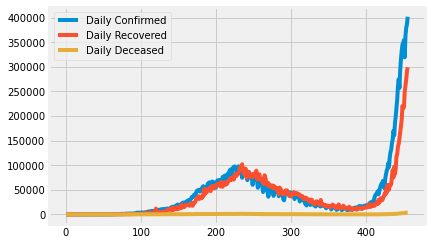

In [12]:
cols = list(case_file)[1:4]

df_for_training = case_file[cols].astype(float)

df_for_plot = df_for_training.tail(500)
df_for_plot.plot.line()

In [13]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

trainX = []
trainY = []
n_feature = 1
n_past = 100

for i in range(n_past, len(df_for_training_scaled) - n_feature +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_feature - 1:i + n_feature, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (357, 100, 3).
trainY shape == (357, 1).


In [14]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

trainY=np.asarray(trainY).astype(np.float32)
history = model.fit(trainX, trainY, epochs=300, batch_size=16, validation_split=0.2, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 64)           17408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
21/21 [==============================] - 11s 365ms/step - loss: 0.1188 - val_loss: 4.8893
Epoch 2/300
21/21 [==============================] - 1s 58ms/step - loss: 0.0516 - val_loss: 4.5698
Epoch 3/300
21/21 [=============================

21/21 [==============================] - 1s 51ms/step - loss: 0.0194 - val_loss: 0.8969
Epoch 74/300
21/21 [==============================] - 1s 52ms/step - loss: 0.0174 - val_loss: 6.9292
Epoch 75/300
21/21 [==============================] - 1s 52ms/step - loss: 0.0213 - val_loss: 1.6803
Epoch 76/300
21/21 [==============================] - 1s 51ms/step - loss: 0.0192 - val_loss: 4.9765
Epoch 77/300
21/21 [==============================] - 1s 52ms/step - loss: 0.0205 - val_loss: 26.4342
Epoch 78/300
21/21 [==============================] - 1s 51ms/step - loss: 0.0189 - val_loss: 32.7967
Epoch 79/300
21/21 [==============================] - 1s 52ms/step - loss: 0.0192 - val_loss: 154.3006
Epoch 80/300
21/21 [==============================] - 1s 51ms/step - loss: 0.0165 - val_loss: 99.1389
Epoch 81/300
21/21 [==============================] - 1s 51ms/step - loss: 0.0194 - val_loss: 67.5990
Epoch 82/300
21/21 [==============================] - 1s 51ms/step - loss: 0.0188 - val_loss: 21.7

21/21 [==============================] - 1s 53ms/step - loss: 0.0196 - val_loss: 3.2789
Epoch 154/300
21/21 [==============================] - 1s 53ms/step - loss: 0.0151 - val_loss: 2.9443
Epoch 155/300
21/21 [==============================] - 1s 53ms/step - loss: 0.0170 - val_loss: 2.5544
Epoch 156/300
21/21 [==============================] - 1s 54ms/step - loss: 0.0144 - val_loss: 2.4883
Epoch 157/300
21/21 [==============================] - 1s 52ms/step - loss: 0.0160 - val_loss: 1.9751
Epoch 158/300
21/21 [==============================] - 1s 53ms/step - loss: 0.0238 - val_loss: 2.1540
Epoch 159/300
21/21 [==============================] - 1s 53ms/step - loss: 0.0200 - val_loss: 2.1998
Epoch 160/300
21/21 [==============================] - 1s 54ms/step - loss: 0.0149 - val_loss: 2.1068
Epoch 161/300
21/21 [==============================] - 1s 54ms/step - loss: 0.0184 - val_loss: 2.6447
Epoch 162/300
21/21 [==============================] - 1s 57ms/step - loss: 0.0208 - val_loss: 3

21/21 [==============================] - 1s 50ms/step - loss: 0.0204 - val_loss: 2.1356
Epoch 234/300
21/21 [==============================] - 1s 50ms/step - loss: 0.0215 - val_loss: 3.0948
Epoch 235/300
21/21 [==============================] - 1s 52ms/step - loss: 0.0163 - val_loss: 2.5697
Epoch 236/300
21/21 [==============================] - 1s 51ms/step - loss: 0.0185 - val_loss: 2.7204
Epoch 237/300
21/21 [==============================] - 1s 51ms/step - loss: 0.0184 - val_loss: 2.1724
Epoch 238/300
21/21 [==============================] - 1s 51ms/step - loss: 0.0150 - val_loss: 2.0046
Epoch 239/300
21/21 [==============================] - 1s 53ms/step - loss: 0.0225 - val_loss: 2.2156
Epoch 240/300
21/21 [==============================] - 1s 52ms/step - loss: 0.0243 - val_loss: 2.1480
Epoch 241/300
21/21 [==============================] - 1s 51ms/step - loss: 0.0178 - val_loss: 2.4783
Epoch 242/300
21/21 [==============================] - 1s 51ms/step - loss: 0.0207 - val_loss: 1

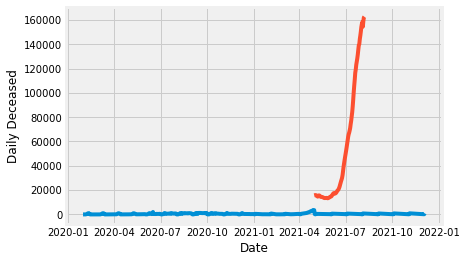

In [15]:
n_future=100  #Redefining n_future to extend prediction dates beyond original n_future dates...
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

forecast = model.predict(trainX[-n_future:]) #forecast 

forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Daily Deceased':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

original = case_file[['Date', 'Daily Deceased']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '30-01-2020']

sns.lineplot(original['Date'], original['Daily Deceased'])
sns.lineplot(df_forecast['Date'], df_forecast['Daily Deceased'])